# Feature Engineering

## Objectives:
- Develop a set of features that have a potential to improve your model's performance
- Investiage the relationships between your new features and your target

In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Identify and remove highly correlated features (to avoid multicolinearity --> avoid overfitting)
from feature_engine.selection import SmartCorrelatedSelection

Data ingestion

In [132]:
dataframe = pd.read_csv("/mnt/c/Users/haanh/api-behavior-anomaly/data/supervised_clean_data.csv")
api_call_graph = pd.read_json("/mnt/d/Opportunities/Jobs/datasets/api_anomaly/supervised_call_graphs.json")

In [133]:
# Checking the graph dataset
api_call_graph.head(3)

,_id,call_graph
0,1f2c32d8-2d6e-3b68-bc46-789469f2b71e,[{'toId': '1f873432-6944-3df9-8300-8a3cf9f95b3...
1,4c486414-d4f5-33f6-b485-24a8ed2925e8,[{'toId': '016099ea-6f20-3fec-94cf-f7afa239f39...
2,7e5838fc-bce1-371f-a3ac-d8a0b2a05d9a,[{'toId': '1f873432-6944-3df9-8300-8a3cf9f95b3...


### Some notes about the graph data
- The call_graph column in the graph dataset (JSON file) contains a list of structures that represent relationships between nodes and edges.
- Each structure provides information about the source and destination nodes and edges.
- A graph comprises source and destination nodes that correspond to the available API calls.
- The call_graph will be analyzed further to extract engineered features from the graph.

### Some notes about the relationship between the tabular data and the graph data
- The cleaned CSV file primarily consists of engineered features, with minimal null values and no significant outliers, making further feature engineering on it potentially less impactful. Instead, additional features will be derived from the graph dataset through feature engineering.
- These additional features from the graph dataset will eventually be integrated into the cleaned CSV file using the _id column.

## Processing the graph data

In [134]:
# Explode the list of dictionaries in call_graph into multiple rows
# In simpler terms, each row contains 1 dictionary from the list of dictionaries in call_graph
# Note: _id value from the original row is repeated for each element in the exploded list
calls_exploded = api_call_graph.explode("call_graph").reset_index(drop=True)

# Normalize the exploded dictionaries into separate columns
# At the start, each dictionary looks like this: 0 {"toID": "B", "fromID": "A"}
# For example
#     toID   fromID
# 0   B      A
# 1   C      B
calls_normalized = pd.json_normalize(calls_exploded['call_graph'])

# Concatenate the original DataFrame (without 'call_graph') with the normalized DataFrame
# In simpler terms, joining _id column with the normalized DataFrame
calls_processed = pd.concat(
    [calls_exploded.drop(columns=['call_graph']).reset_index(drop=True),
     calls_normalized.reset_index(drop=True)],
    axis=1
)  # axis=1 as I want to concatenate the DataFrames side by side (or horizontally)

# Extra: rename "toId" to "to", and "fromId" to "from" to avoid reading as "told" and "fromid" (easier understanding)
# Rename the columns fromID and toID to from and to
calls_processed.rename(columns={'fromId': 'from', 'toId': 'to'}, inplace=True)

# Display the first 3 rows
calls_processed.head(3)

,_id,to,from
0,1f2c32d8-2d6e-3b68-bc46-789469f2b71e,1f873432-6944-3df9-8300-8a3cf9f95b35,5862055b-35a6-316a-8e20-3ae20c1763c2
1,1f2c32d8-2d6e-3b68-bc46-789469f2b71e,8955faa9-0e33-37ad-a1dc-f0e640a114c2,a4fd6415-1fd4-303e-aa33-bb1830b5d9d4
2,1f2c32d8-2d6e-3b68-bc46-789469f2b71e,85754db8-6a55-30b7-8558-dec75ff89abd,85754db8-6a55-30b7-8558-dec75ff89abd


### Checking for null values in the graph data

In [135]:
missing_calls = calls_processed[calls_processed.isnull().any(axis=1)]

missing_calls.head()

,_id,to,from
408116,286cf539-f6df-3af7-a0d9-fd9c0149b5d5,NaN,NaN
414714,8e8b99bb-7b6d-3437-9abc-1d884fe023d0,NaN,NaN
414860,bedfd600-80ef-3e95-8667-fa0d9a905d72,NaN,NaN
416318,60a25ad0-add8-3976-bc51-a7ff6779d5dc,NaN,NaN
417300,70b6a9dd-e4c6-36a0-908d-2311c277b5e8,NaN,NaN


There are 5 ids with no nodes concerning them. All of these ids, except 286cf539-f6df-3af7-a0d9-fd9c0149b5d5, have missing values in the tabular data (csv file). 
Hence, all of these 5 rows with these ids will be deleted from the graph data because graphs cannot be built with null nodes. 
Additionally, the row with the id 286cf539-f6df-3af7-a0d9-fd9c0149b5d5 will be deleted from the tabular data because there is no point to link non-existent information from the graph data with the existent information from the tabular data.

In [136]:
# Drop rows with null value from the graph data
calls_processed = calls_processed.dropna()

## Conducting feature engineering
### Basic graph level features
The most basic graph-level that we can engineer are:
- Number of edges (connections)
- Number of nodes (APIs)

These features can be useful since most behaviours are going to have a "normal" range of APIs that they contact. If this number is too large or too small, this might be an indication of anomalous activity.

In [137]:
# Group by '_id' and aggregate the number of connections and unique from/to values
graph_features = calls_processed.groupby('_id').agg(
    n_connections=('from', 'count'),  # Count number of 'from' entries
    from_nodes=('from', lambda x: list(set(x))),  # Gather all unique 'from' values
    to_nodes=('to', lambda x: list(set(x)))         # Gather all unique 'to' values
).reset_index()

# Calculate the number of unique nodes (both to_nodes and from_nodes) concerning each _id
graph_features['n_unique_nodes'] = graph_features.apply(
    lambda row: len(set(row['from_nodes'] + row['to_nodes'])),
    axis=1
)
# Display the features in graph_features so far
graph_features.head(3)

,_id,n_connections,from_nodes,to_nodes,n_unique_nodes
0,00041830-3168-3731-8bbc-c6838311da58,28,"[257b9618-6c20-3fd2-89a2-c53961eab4ef, 7c4ed48...","[257b9618-6c20-3fd2-89a2-c53961eab4ef, 7c4ed48...",15
1,007fa202-d51f-3619-8104-779c31c30138,57,"[66837568-9caf-35e7-b7bc-f6d907b9dfac, d8ab934...","[552c5e80-557f-3108-a126-27aa1371a5f1, d8ab934...",30
2,00b35506-6ac8-3726-a9f6-4adbedd5bc0c,57,"[257b9618-6c20-3fd2-89a2-c53961eab4ef, 47a9d8f...","[257b9618-6c20-3fd2-89a2-c53961eab4ef, 2e8ac1d...",35


### Note
From this point, from_nodes and to_nodes do not serve any more value so they will be dropped

In [138]:
# Drop 'from_nodes' and 'to_nodes'
graph_features = graph_features.drop(['from_nodes', 'to_nodes'], axis=1)

# Check the dataframe
graph_features.head(3)

,_id,n_connections,n_unique_nodes
0,00041830-3168-3731-8bbc-c6838311da58,28,15
1,007fa202-d51f-3619-8104-779c31c30138,57,30
2,00b35506-6ac8-3726-a9f6-4adbedd5bc0c,57,35


### Further graph level features
Based on the data in the json file about the graph, we can explore several other features of the graph on the nodeand edge level, namely:
- Degree Centrality: Measure of the number of connections a node has. This can be broken down into 2 features: in-degree and out-degree. In-degree is the number of incoming connections (edges) to each node, representing how many times the node is referenced as a "to" node. Out-degree is the number of outgoing connections from each node, which is essentially the same as n_connections but confirms the count of edges leading out from the node.
- Clustering Coefficient: A measure of the degree to which nodes in the graph tend to cluster together. A higher coefficient indicates that nodes' neighbors are also connected.
- Node Importance Measures: Calculate measures like PageRank or betweenness centrality for node importance. Additionally, higher values indicate more important nodes.

I can calculate degree centrality, clustering coefficients, and PageRank for each node but the whole dataset, both the tabular data and graph data, gear towards getting overall statistics by each _id, not by individual nodes associated with each _id. Hence, I will be getting the summary measures (total, min, max, standard deviation, mean) for each of in_degree, out_degree, clustering_coefficient, and PageRank for each _id.

In [139]:
import networkx as nx

# Create an empty DataFrame to hold aggregated node and edge features per _id
node_edge_features = pd.DataFrame()

# Get unique _id values from the calls_processed DataFrame
unique_ids = calls_processed['_id'].unique()

# Loop through each unique _id
for _id in unique_ids:
    # Create a subgraph for the current _id
    sub_calls_processed = calls_processed[calls_processed['_id'] == _id]
    
    # Create a directed graph from the processed DataFrame for the current _id
    G = nx.from_pandas_edgelist(
        sub_calls_processed,
        source='from',
        target='to',
        create_using=nx.DiGraph()
    )
    
    # Get the list of nodes in the subgraph
    nodes_in_graph = G.nodes()
    
    # Calculate in-degree and out-degree for each node in the subgraph
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    
    # Calculate clustering coefficient for each node in the subgraph
    clustering_coeffs = nx.clustering(G.to_undirected())
    
    # Node importance measures (like PageRank)
    page_rank = nx.pagerank(G)
    
    # Gather metrics for aggregation
    in_degree_values = [in_degree[node] for node in nodes_in_graph]
    out_degree_values = [out_degree[node] for node in nodes_in_graph]
    clustering_coefficient_values = [clustering_coeffs.get(node, 0) for node in nodes_in_graph]
    page_rank_values = [page_rank.get(node, 0) for node in nodes_in_graph]

    # Aggregate values for the current _id
    total_in_degree = sum(in_degree_values)
    total_out_degree = sum(out_degree_values)
    total_clustering_coefficient = sum(clustering_coefficient_values)
    total_page_rank = sum(page_rank_values)
    
    # Calculate statistics for each metric
    num_nodes = len(nodes_in_graph)
    mean_in_degree = total_in_degree / num_nodes if num_nodes > 0 else 0
    mean_out_degree = total_out_degree / num_nodes if num_nodes > 0 else 0
    mean_clustering_coefficient = total_clustering_coefficient / num_nodes if num_nodes > 0 else 0
    mean_page_rank = total_page_rank / num_nodes if num_nodes > 0 else 0
    
    min_in_degree = min(in_degree_values) if in_degree_values else 0
    max_in_degree = max(in_degree_values) if in_degree_values else 0
    std_in_degree = pd.Series(in_degree_values).std() if len(in_degree_values) > 1 else 0

    min_out_degree = min(out_degree_values) if out_degree_values else 0
    max_out_degree = max(out_degree_values) if out_degree_values else 0
    std_out_degree = pd.Series(out_degree_values).std() if len(out_degree_values) > 1 else 0
    
    min_clustering_coefficient = min(clustering_coefficient_values) if clustering_coefficient_values else 0
    max_clustering_coefficient = max(clustering_coefficient_values) if clustering_coefficient_values else 0
    std_clustering_coefficient = pd.Series(clustering_coefficient_values).std() if len(clustering_coefficient_values) > 1 else 0
    
    min_page_rank = min(page_rank_values) if page_rank_values else 0
    max_page_rank = max(page_rank_values) if page_rank_values else 0
    std_page_rank = pd.Series(page_rank_values).std() if len(page_rank_values) > 1 else 0

    # Create a new DataFrame for the current _id with aggregated metrics and statistics
    sub_node_edge_features = pd.DataFrame({
        '_id': [_id],
        'total_in_degree': [total_in_degree],
        'total_out_degree': [total_out_degree],
        'total_clustering_coefficient': [total_clustering_coefficient],
        'total_page_rank': [total_page_rank],
        'num_nodes': [num_nodes],
        'mean_in_degree': [mean_in_degree],
        'mean_out_degree': [mean_out_degree],
        'mean_clustering_coefficient': [mean_clustering_coefficient],
        'mean_page_rank': [mean_page_rank],
        'min_in_degree': [min_in_degree],
        'max_in_degree': [max_in_degree],
        'std_in_degree': [std_in_degree],
        'min_out_degree': [min_out_degree],
        'max_out_degree': [max_out_degree],
        'std_out_degree': [std_out_degree],
        'min_clustering_coefficient': [min_clustering_coefficient],
        'max_clustering_coefficient': [max_clustering_coefficient],
        'std_clustering_coefficient': [std_clustering_coefficient],
        'min_page_rank': [min_page_rank],
        'max_page_rank': [max_page_rank],
        'std_page_rank': [std_page_rank]
    })

    # Append the results to the main DataFrame
    node_edge_features = pd.concat([node_edge_features, sub_node_edge_features], ignore_index=True)

# Display the final node_edge_features DataFrame
node_edge_features.head(6)


,_id,total_in_degree,total_out_degree,total_clustering_coefficient,total_page_rank,num_nodes,mean_in_degree,mean_out_degree,mean_clustering_coefficient,mean_page_rank,...,std_in_degree,min_out_degree,max_out_degree,std_out_degree,min_clustering_coefficient,max_clustering_coefficient,std_clustering_coefficient,min_page_rank,max_page_rank,std_page_rank
0,1f2c32d8-2d6e-3b68-bc46-789469f2b71e,2821,2821,233.511011,1.0,447,6.310962,6.310962,0.522396,0.002237,...,11.022579,0,164,12.437627,0.0,1.0,0.326862,0.000365,0.073419,0.004533
1,4c486414-d4f5-33f6-b485-24a8ed2925e8,1270,1270,127.723204,1.0,280,4.535714,4.535714,0.456154,0.003571,...,7.308767,0,65,8.032560,0.0,1.0,0.358520,0.000623,0.083286,0.006145
2,7e5838fc-bce1-371f-a3ac-d8a0b2a05d9a,1589,1589,149.883269,1.0,354,4.488701,4.488701,0.423399,0.002825,...,6.853062,0,93,8.253844,0.0,1.0,0.354173,0.000466,0.069983,0.004735
3,82661ecd-d87f-3dff-855e-378f7cb6d912,459,459,48.883829,1.0,114,4.026316,4.026316,0.428806,0.008772,...,4.951911,0,28,5.228344,0.0,1.0,0.365332,0.001546,0.072088,0.009683
4,d62d56ea-775e-328c-8b08-db7ad7f834e5,89,89,12.104285,1.0,23,3.869565,3.869565,0.526273,0.043478,...,2.881041,1,9,2.282430,0.0,1.0,0.311825,0.006522,0.157030,0.034735
5,45d84ed6-043b-39ba-9247-0e5c36c48889,2520,2520,207.126971,1.0,425,5.929412,5.929412,0.487358,0.002353,...,10.355461,0,137,11.313488,0.0,1.0,0.325058,0.000379,0.083754,0.004937


In [140]:
# Merge back with the original graph_features based on unique node connections
graph_features_merged = pd.merge(graph_features, node_edge_features, how='left', on='_id')

# Display the final dataframe
graph_features_merged.head(3)

,_id,n_connections,n_unique_nodes,total_in_degree,total_out_degree,total_clustering_coefficient,total_page_rank,num_nodes,mean_in_degree,mean_out_degree,...,std_in_degree,min_out_degree,max_out_degree,std_out_degree,min_clustering_coefficient,max_clustering_coefficient,std_clustering_coefficient,min_page_rank,max_page_rank,std_page_rank
0,00041830-3168-3731-8bbc-c6838311da58,28,15,28,28,6.488889,1.0,15,1.866667,1.866667,...,0.915475,0,10,2.695676,0.0,1.0,0.453858,0.014776,0.297744,0.075684
1,007fa202-d51f-3619-8104-779c31c30138,57,30,57,57,7.593651,1.0,30,1.900000,1.900000,...,1.470398,0,6,1.470398,0.0,1.0,0.335599,0.005478,0.095825,0.022750
2,00b35506-6ac8-3726-a9f6-4adbedd5bc0c,57,35,57,57,14.838023,1.0,35,1.628571,1.628571,...,1.476994,0,6,1.699234,0.0,1.0,0.460355,0.007390,0.090682,0.018961


### Observations:
Since the total Page Rank of each _id is 1. 'total_page_rank' will be dropped from the dataframe.

In [141]:
graph_features_merged = graph_features_merged.drop('total_page_rank', axis=1)

graph_features_merged.head(3)

,_id,n_connections,n_unique_nodes,total_in_degree,total_out_degree,total_clustering_coefficient,num_nodes,mean_in_degree,mean_out_degree,mean_clustering_coefficient,...,std_in_degree,min_out_degree,max_out_degree,std_out_degree,min_clustering_coefficient,max_clustering_coefficient,std_clustering_coefficient,min_page_rank,max_page_rank,std_page_rank
0,00041830-3168-3731-8bbc-c6838311da58,28,15,28,28,6.488889,15,1.866667,1.866667,0.432593,...,0.915475,0,10,2.695676,0.0,1.0,0.453858,0.014776,0.297744,0.075684
1,007fa202-d51f-3619-8104-779c31c30138,57,30,57,57,7.593651,30,1.900000,1.900000,0.253122,...,1.470398,0,6,1.470398,0.0,1.0,0.335599,0.005478,0.095825,0.022750
2,00b35506-6ac8-3726-a9f6-4adbedd5bc0c,57,35,57,57,14.838023,35,1.628571,1.628571,0.423944,...,1.476994,0,6,1.699234,0.0,1.0,0.460355,0.007390,0.090682,0.018961


In [110]:
# Check for duplicate rows
duplicates = graph_features_merged[graph_features_merged.duplicated()]
duplicate_count = duplicates.shape[0]
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


## Feature selection
Feature selection will be done using 2 steps:
1. Quality checks - if the feature is constant or has too many missing values (>= 95%) it will be dropped
2. Correlation analysis - if features have very high correlation (>= 95%) with each other, they can be dropped as well

In [112]:
# Engineered features are the features containing numeric values in the graph_features_merged since we need to calculate them (hence, engineered)
engineered_features = graph_features_merged.select_dtypes(include=['number']).columns.tolist()
print(engineered_features)

['n_connections', 'n_unique_nodes', 'total_in_degree', 'total_out_degree', 'total_clustering_coefficient', 'num_nodes', 'mean_in_degree', 'mean_out_degree', 'mean_clustering_coefficient', 'mean_page_rank', 'min_in_degree', 'max_in_degree', 'std_in_degree', 'min_out_degree', 'max_out_degree', 'std_out_degree', 'min_clustering_coefficient', 'max_clustering_coefficient', 'std_clustering_coefficient', 'min_page_rank', 'max_page_rank', 'std_page_rank']


In [113]:
len(engineered_features)

22

I have engineered 22 features from the graph data. We will begin selecting engineered features now.

### Quality check

In [114]:
# Finding columns with missing values
null_columns = graph_features_merged.columns[graph_features_merged.isnull().any()]
print(null_columns)

Index([], dtype='object')


There are no columns with missing values in the engineered graph data.

### Correlation analysis

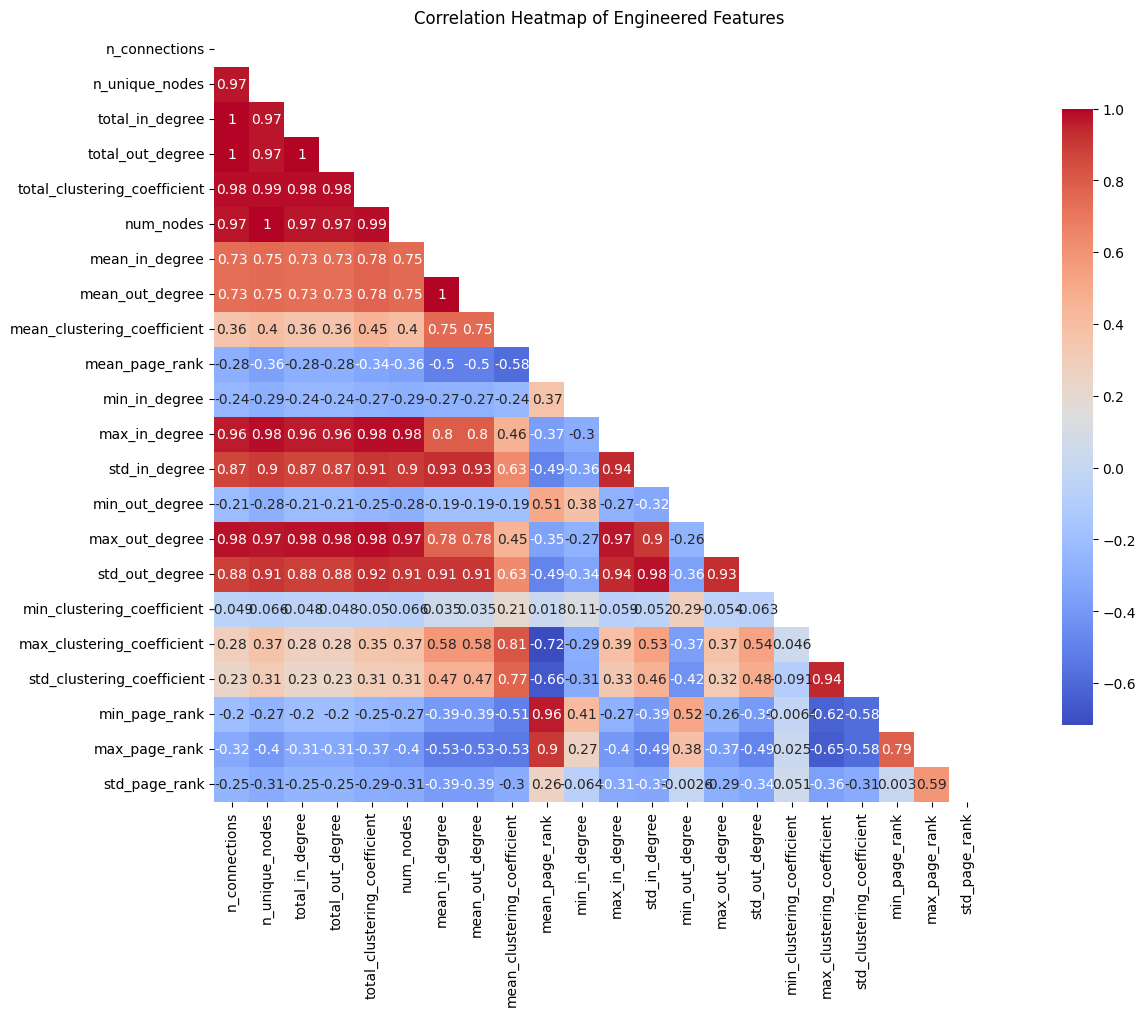

In [115]:
feature_corrs = graph_features_merged[engineered_features].corr()

# Create a mask for the upper triangle (better visualization)
matrix = np.triu(np.ones_like(feature_corrs, dtype=bool))

# Create the heatmap
fig = plt.figure(figsize=(20, 10))
sns.heatmap(feature_corrs, annot=True, mask=matrix, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Show the plot
plt.title('Correlation Heatmap of Engineered Features')
plt.show()

In [118]:
tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.95,
    missing_values="raise",
    selection_method="variance",
    estimator=None,
)

tr.fit(feature_corrs)

print('Features to drop:')
for f in tr.features_to_drop_:
    print(f)

# Deriving features to keep
all_features = feature_corrs.columns.tolist()
features_to_keep = [f for f in all_features if f not in tr.features_to_drop_]

print('Features to keep:')
for f in features_to_keep:
    print(f)


Features to drop:
std_in_degree
max_in_degree
n_unique_nodes
num_nodes
total_clustering_coefficient
max_out_degree
mean_in_degree
mean_out_degree
total_out_degree
total_in_degree
n_connections
max_page_rank
max_clustering_coefficient
min_page_rank
std_clustering_coefficient
mean_clustering_coefficient
Features to keep:
mean_page_rank
min_in_degree
min_out_degree
std_out_degree
min_clustering_coefficient
std_page_rank


Based on the heatmap and the above function, there are 16 features to drop: std_in_degree, max_in_degree, n_unique_nodes, num_nodes, total_clustering_coefficient, max_out_degree, mean_in_degree, mean_out_degree, total_out_degree, total_in_degree, n_connections, max_page_rank, max_clustering_coefficient, min_page_rank, std_clustering_coefficient, mean_clustering_coefficient

The kept features are: mean_page_rank, min_in_degree, min_out_degree, std_out_degree, min_clustering_coefficient, and std_page_rank

In [151]:
# Getting the final engineered graph data
final_graph = graph_features_merged.loc[:, ['_id', 'mean_page_rank', 'min_in_degree', 'std_out_degree', 'min_clustering_coefficient', 'std_page_rank']]

# Display the first three rows of the filtered DataFrame
final_graph.head(3)

,_id,mean_page_rank,min_in_degree,std_out_degree,min_clustering_coefficient,std_page_rank
0,00041830-3168-3731-8bbc-c6838311da58,0.066667,0,2.695676,0.0,0.075684
1,007fa202-d51f-3619-8104-779c31c30138,0.033333,0,1.470398,0.0,0.022750
2,00b35506-6ac8-3726-a9f6-4adbedd5bc0c,0.028571,0,1.699234,0.0,0.018961


## Dataset transformation

1. The tabular data
Concerning _id 286cf539-f6df-3af7-a0d9-fd9c0149b5d5, there is no graph information for this id. Hence, the information related to this _id in the tabular file will be removed.

In [153]:
dataframe = dataframe[dataframe['_id'] != '286cf539-f6df-3af7-a0d9-fd9c0149b5d5']

file_path = '/mnt/c/Users/haanh/api-behavior-anomaly/data/supervised_clean_data.csv'
dataframe.to_csv(file_path, index=False)

2. Combined dataset
Here, we will combine both the tabular and graph dataset together

In [154]:
file_path = '/mnt/c/Users/haanh/api-behavior-anomaly/data/all_features.csv'

all_features = pd.merge(dataframe, final_graph, how='left', on='_id')

all_features.to_csv(file_path, index=False)

## Summary
In this file, I have done processed the graph data, engineered the features, and chosen the non-corellated features. This resulted in the final graph dataset.

The final graph dataset is merged with the clean tabular dataset to make the final dataset for the model. 